In [68]:
library(leaps)

## IMPORTATION DES DONNEES

In [2]:
data_tot = read.csv('./Donnees/Plusieurs_pays/Total.csv', header = TRUE)
data_tot = data_tot[-c(47,60)]

Création d'un nouveau dataframe sans les variables `Rating` et `Pays`, utilisé après :

In [5]:
data = data_tot[,-c(81,82)]

## Sélection de variables

### BIC

In [50]:
choixb <- regsubsets(data_tot$Rating~., data=data,nbest=1, nvmax=10, method="seqrep")
summary(choixb)

Subset selection object
Call: regsubsets.formula(data_tot$Rating ~ ., data = data, nbest = 1, 
    nvmax = 10, method = "seqrep")
80 Variables  (and intercept)
                                  Forced in Forced out
Tackles_TotalTackles                  FALSE      FALSE
Tackles_DribbledPast                  FALSE      FALSE
Tackles_TotalAttemptedTackles         FALSE      FALSE
Interception_Total                    FALSE      FALSE
Fouls_Fouled                          FALSE      FALSE
Fouls_Fouls                           FALSE      FALSE
Cards_Yellow                          FALSE      FALSE
Cards_Red                             FALSE      FALSE
OffSides_CaughtOffside                FALSE      FALSE
Clearances_Total                      FALSE      FALSE
Blocks_ShotsBlocked                   FALSE      FALSE
Blocks_CrossesBlocked                 FALSE      FALSE
Blocks_PassesBlocked                  FALSE      FALSE
Saves_Total                           FALSE      FALSE
Saves_SixYardBo

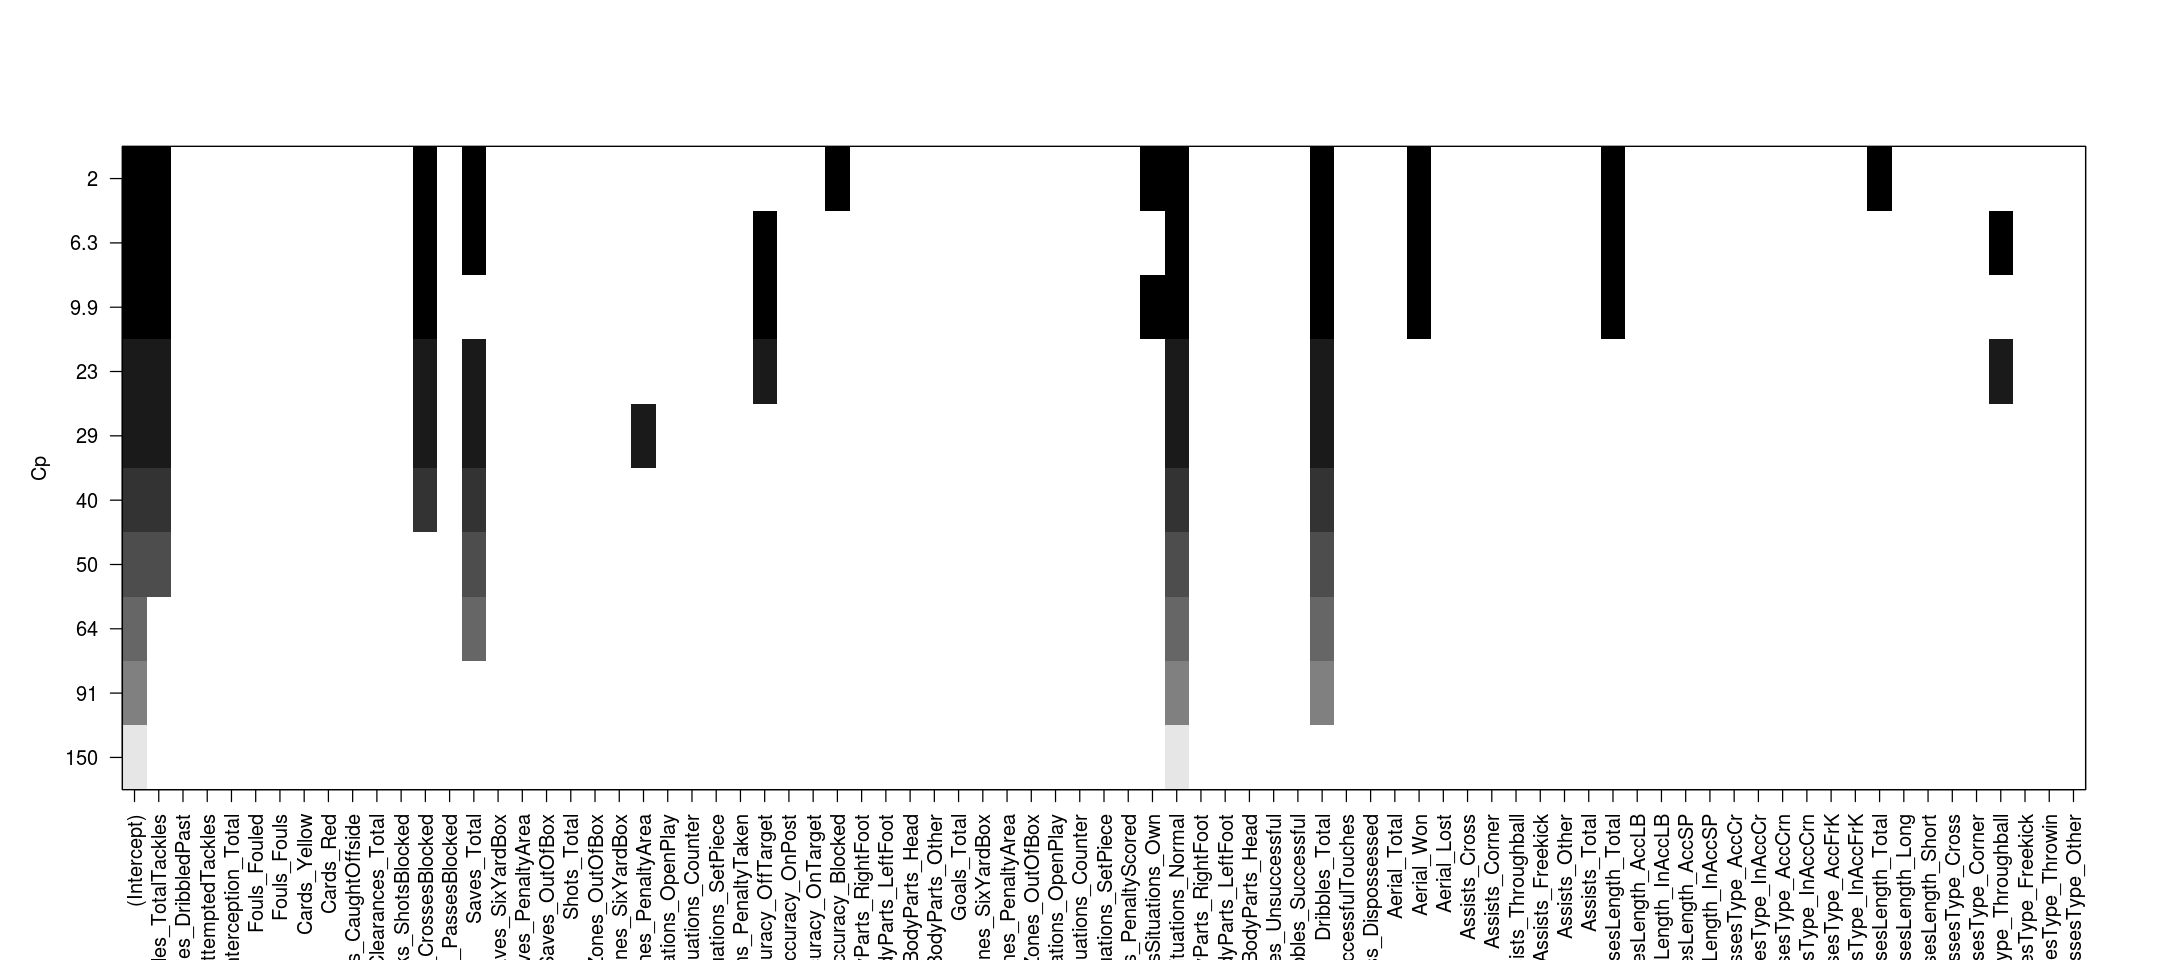

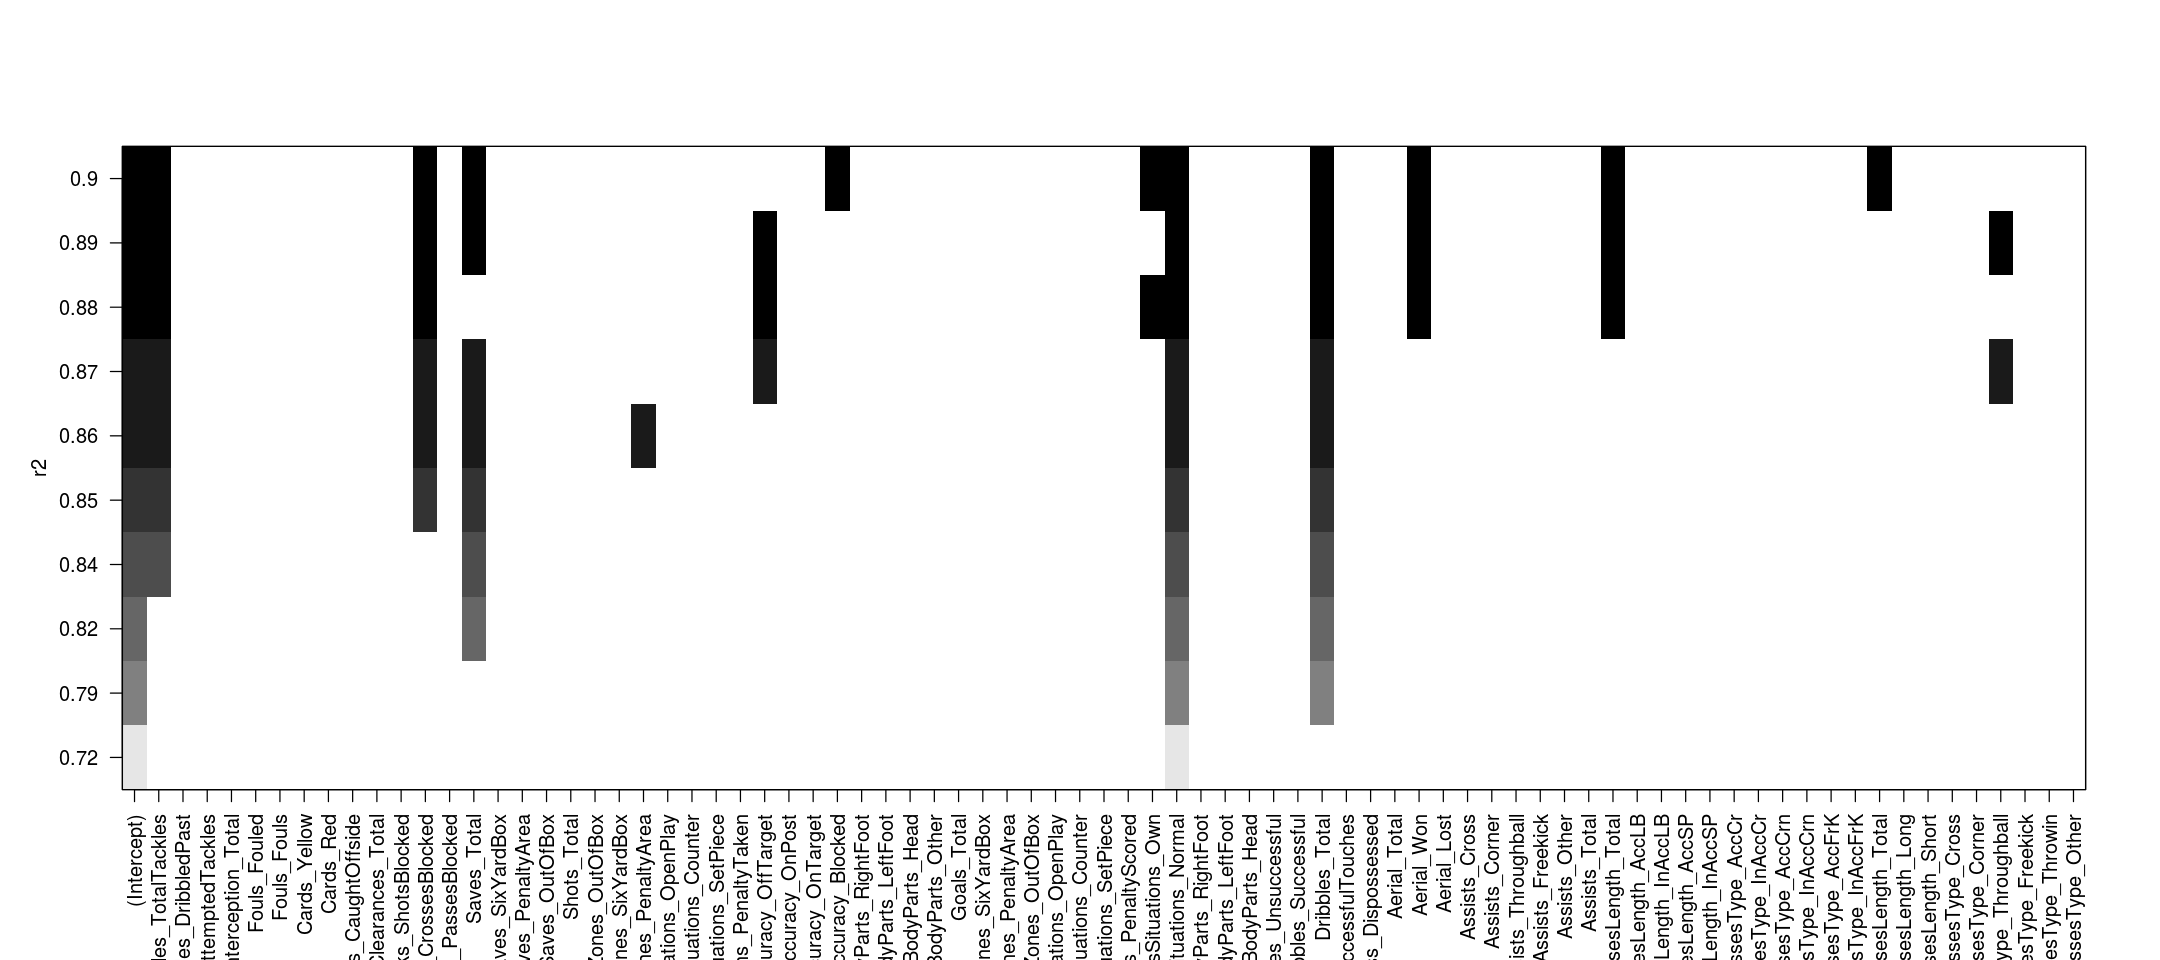

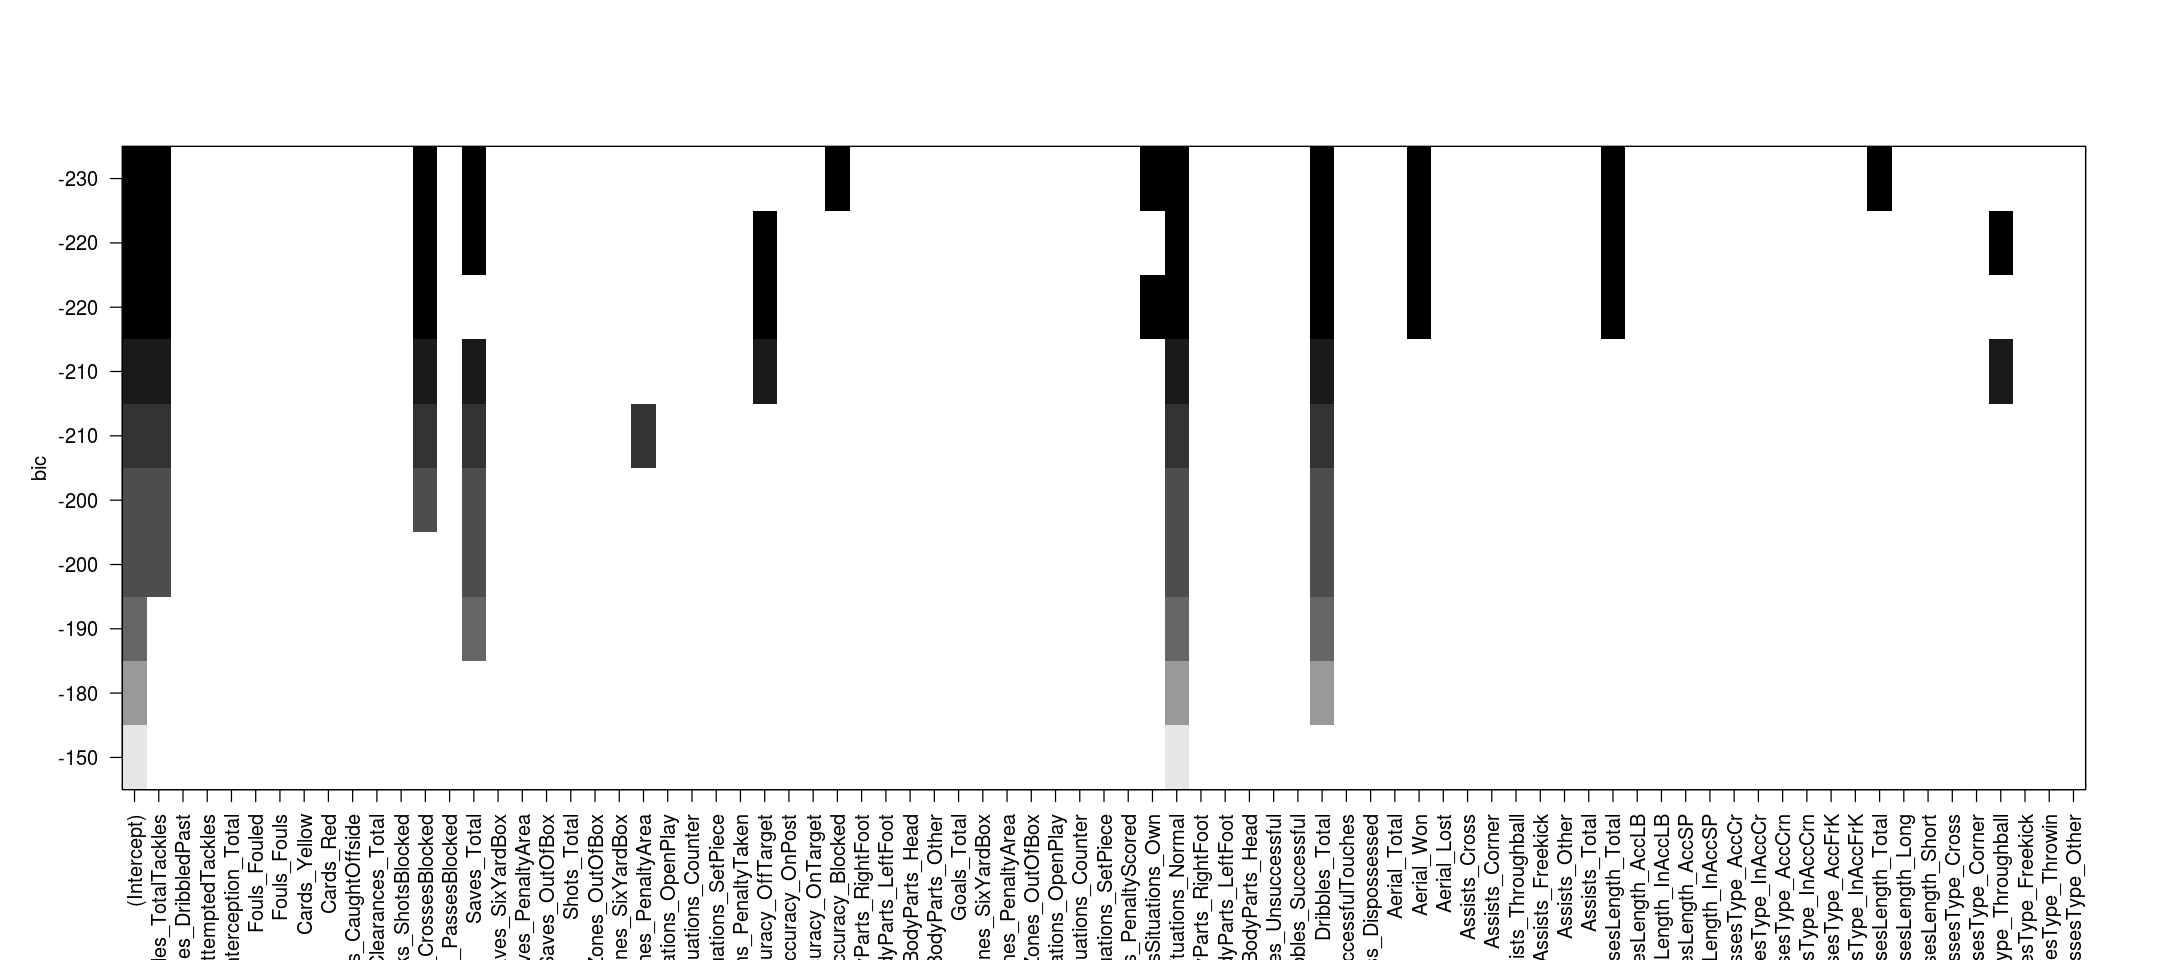

In [51]:
options(repr.plot.width=18, repr.plot.height=8)
plot(choixb,scale="Cp")
plot(choixb,scale="r2")
plot(choixb,scale="bic")

Les trois différents critères utilisés ci-dessus pour la sélection de modèle (Cp de Mallows, R2 et BIC) semblent donner les mêmes résultats.

In [33]:
nb_min = which.min(summary(choixb)$bic)
coef(choixb, nb_min)

(Intercept)   Tackles_TotalTackles  Blocks_CrossesBlocked 
          5.7521591285           0.0116722139           0.0446894206 
           Saves_Total  ShotsAccuracy_Blocked    GoalsSituations_Own 
         -0.0197312817          -0.0298931883           0.2218527960 
GoalsSituations_Normal         Dribbles_Total             Aerial_Won 
          0.1946429462           0.0085251506           0.0070545723 
    PassesLength_Total  KeyPassesLength_Total 
          0.0003693942           0.0189994395

In [37]:
data_bic = data.frame(data_tot$Rating, data_tot$Tackles_TotalTackles, data_tot$Blocks_CrossesBlocked, data_tot$Saves_Total, 
                     data_tot$ShotsAccuracy_Blocked, data_tot$GoalsSituations_Own, data_tot$GoalsSituations_Normal,
                     data_tot$Dribbles_Total, data_tot$Aerial_Won, data_tot$PassesLength_Total, data_tot$KeyPassesLength_Total)

names(data_bic) <- c("Rating", "Tackles_TotalTackles", "Blocks_CrossesBlocked", "Saves_Total", "ShotsAccuracy_Blocked", 
                     "GoalsSituations_Own", "GoalsSituations_Normal", "Dribbles_Total", "Aerial_Won",
                     "PassesLength_Total", "KeyPassesLength_Total")

In [46]:
reg_bic = lm(Rating~(.)^2, data = data_bic)

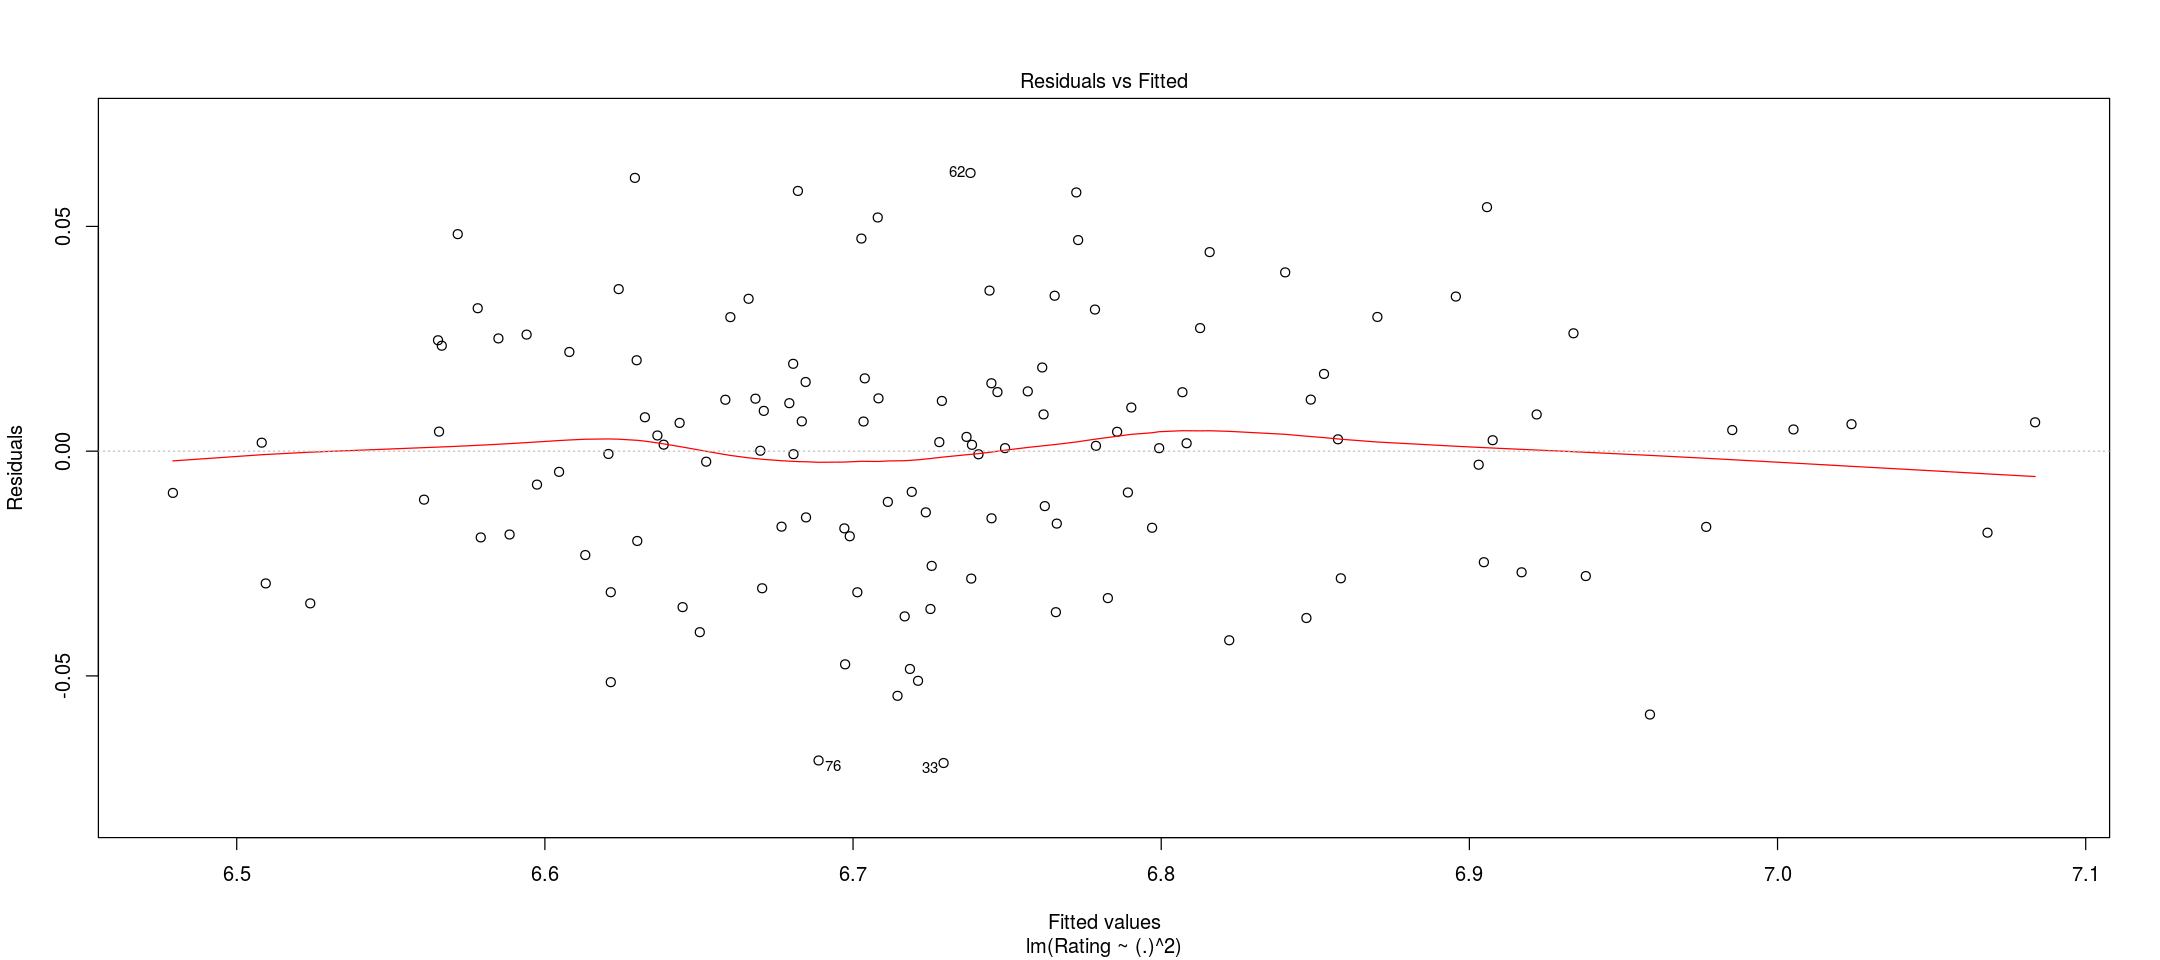

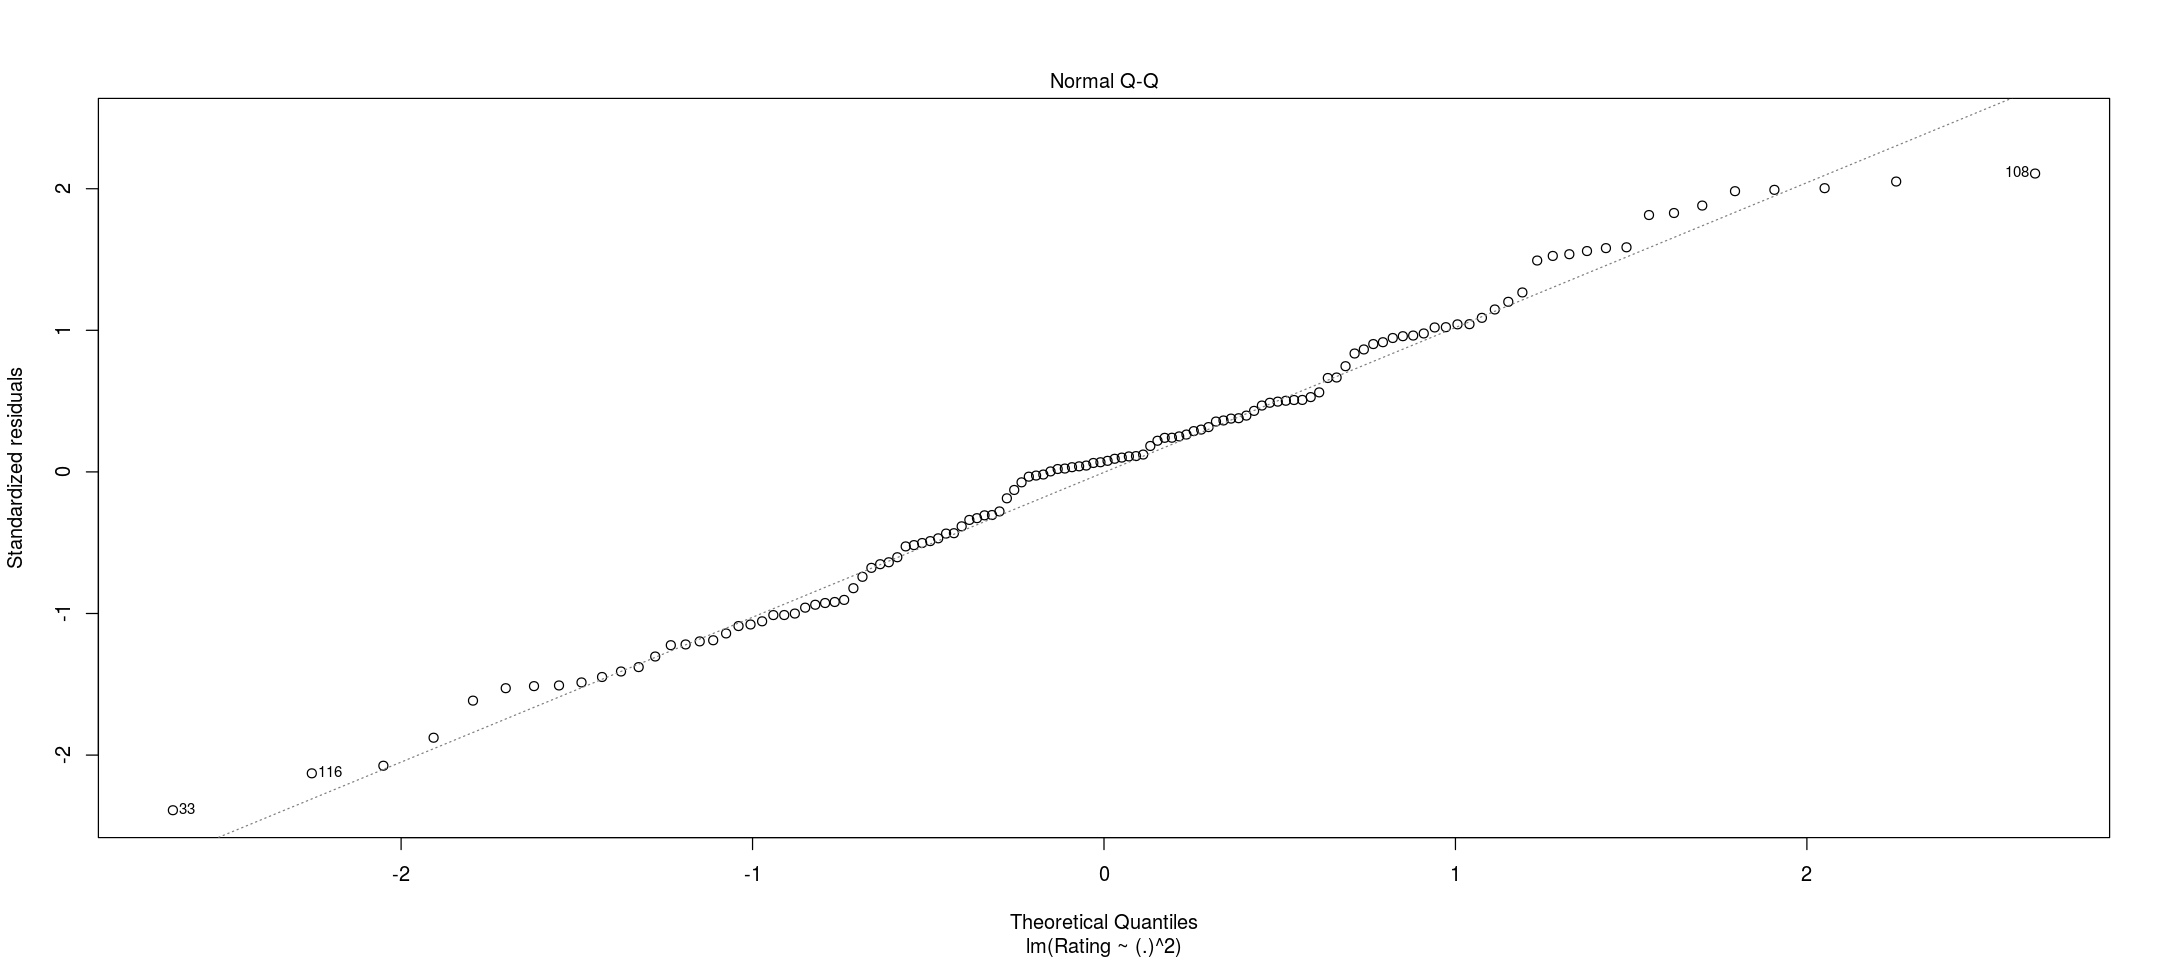

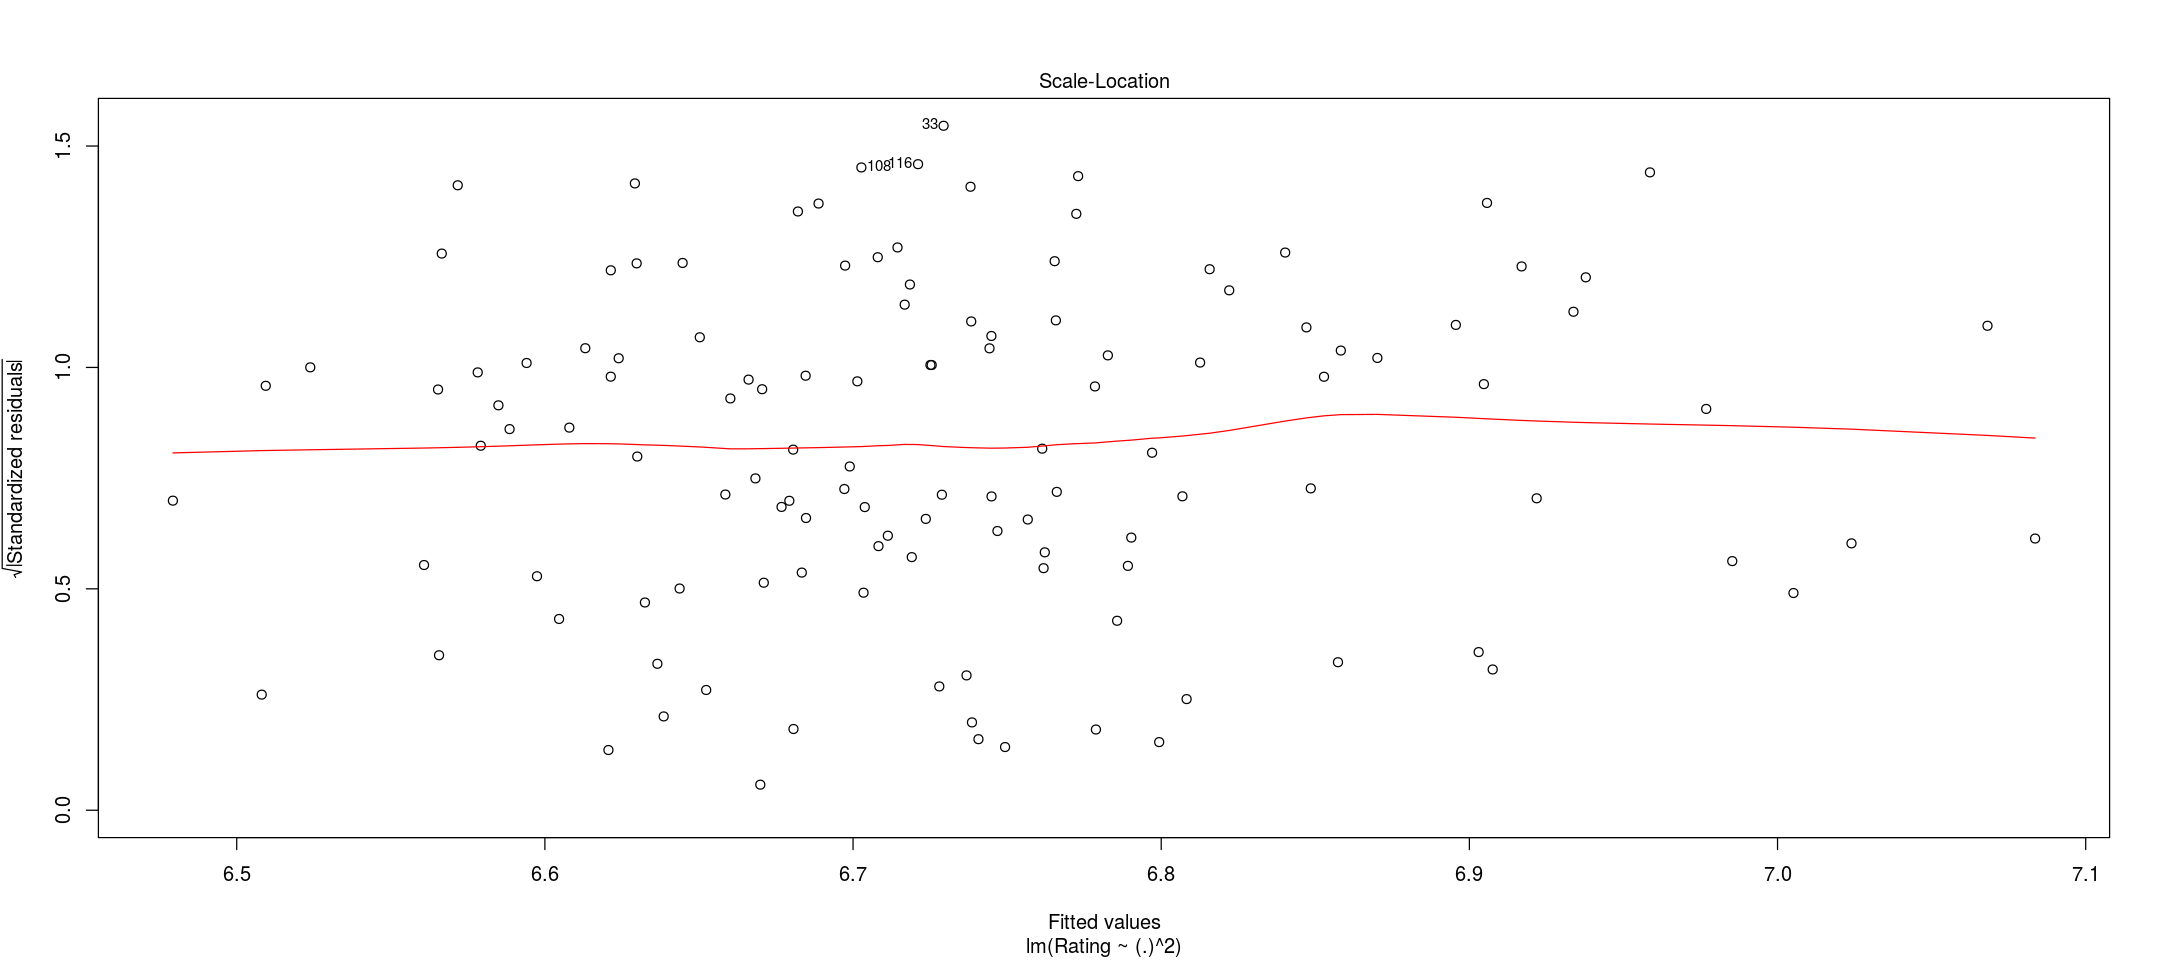

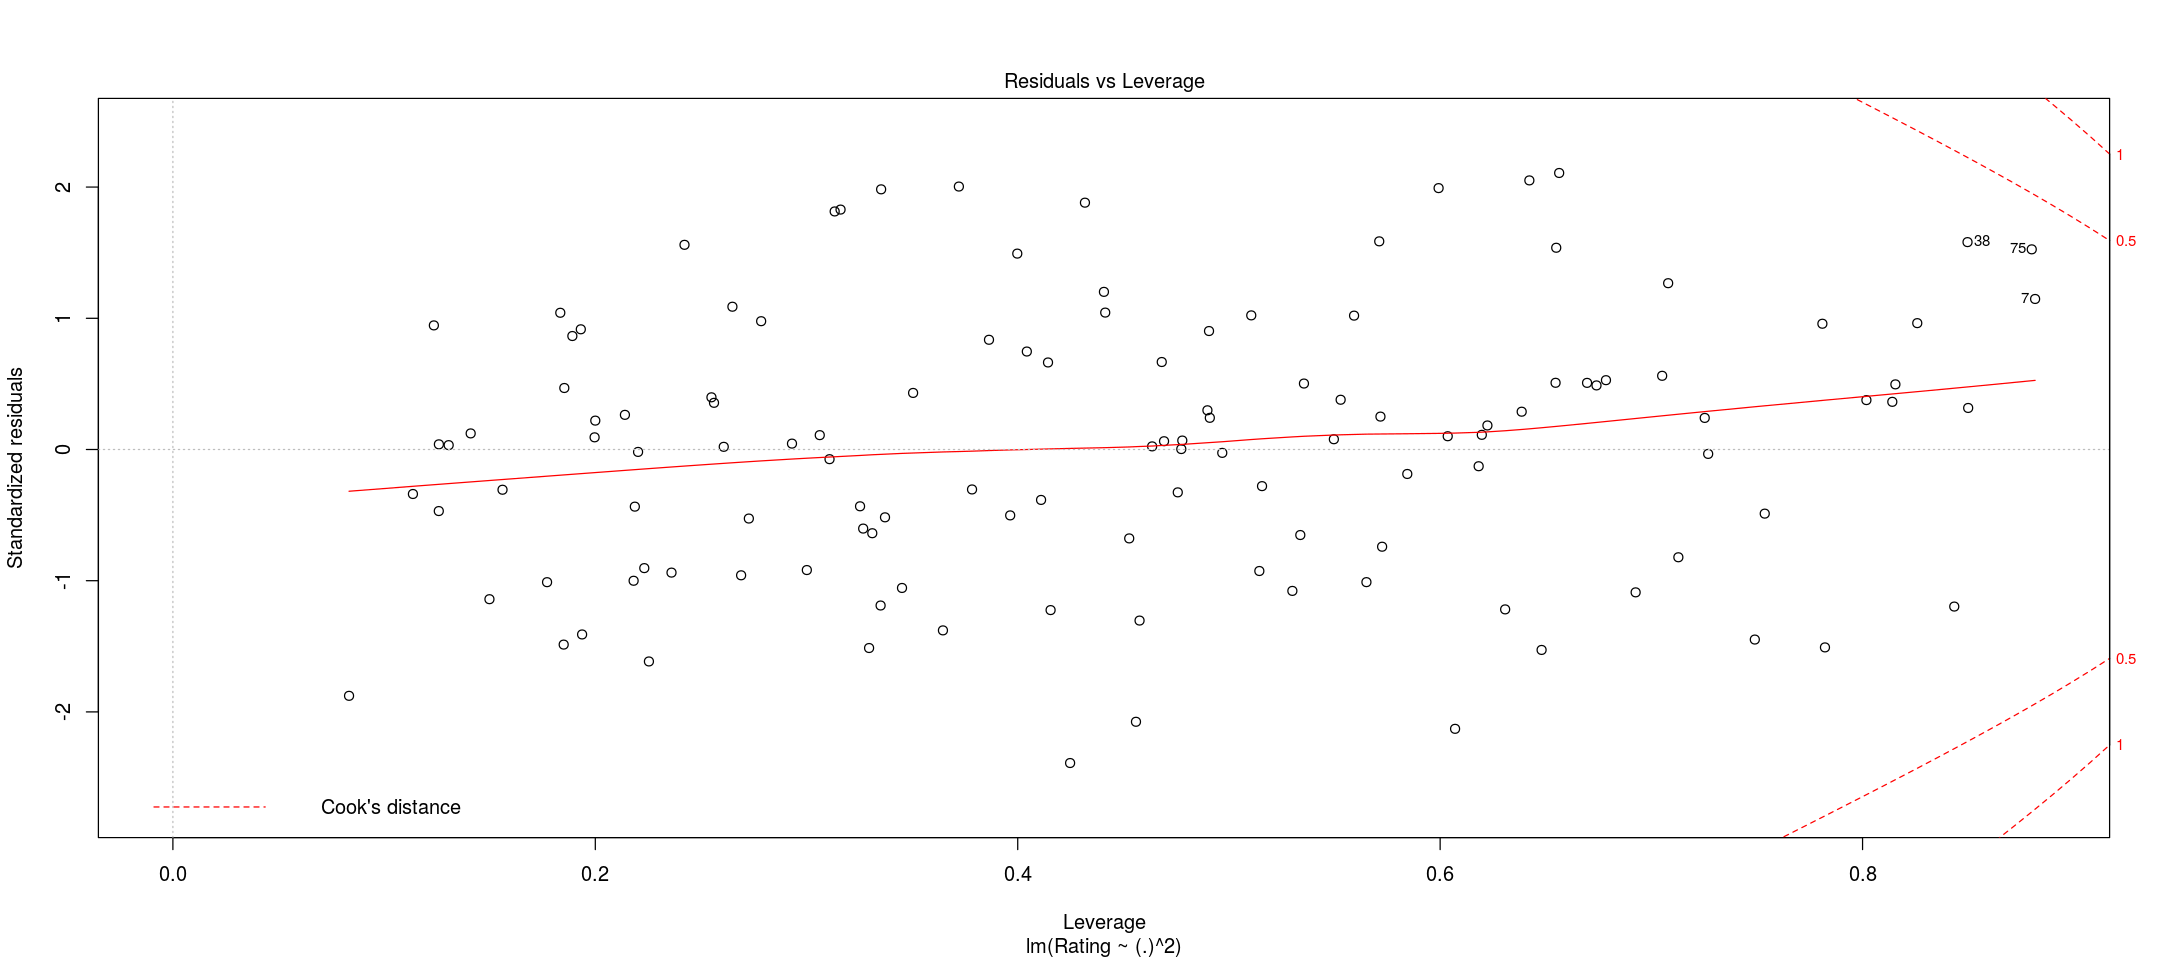

In [47]:
plot(reg_bic)

On voit que le graphe des résidus ne présente pas de forme particulière. De plus, le graphe quantile-quantile est plus ou moins aligné (quelques soucis sur les petits et grands quantiles).

On va refaire de la sélection de variables, mais pour chaque pays, et ainsi observer les variables vraiment influentes.

In [56]:
France = data[data_tot$Pays == "France",]
Allemagne = data[data_tot$Pays == "Allemagne",]
Italie = data[data_tot$Pays == "Italie",]
Espagne = data[data_tot$Pays == "Espagne",]
Argentine = data[data_tot$Pays == "Argentine",]
Angleterre = data[data_tot$Pays == "Angleterre",]

In [60]:
choix_France <- regsubsets(data_tot[data_tot$Pays=="France",]$Rating~., data=France,nbest=1, nvmax=10, method="seqrep")
choix_Allemagne <- regsubsets(data_tot[data_tot$Pays=="Allemagne",]$Rating~., data=Allemagne,nbest=1, nvmax=10, method="seqrep")
choix_Italie <- regsubsets(data_tot[data_tot$Pays=="Italie",]$Rating~., data=Italie,nbest=1, nvmax=10, method="seqrep")
choix_Espagne <- regsubsets(data_tot[data_tot$Pays=="Espagne",]$Rating~., data=Espagne,nbest=1, nvmax=10, method="seqrep")
choix_Argentine <- regsubsets(data_tot[data_tot$Pays=="Argentine",]$Rating~., data=Argentine, nbest=1, nvmax=10, method="seqrep")
choix_Angleterre <- regsubsets(data_tot[data_tot$Pays=="Angleterre",]$Rating~., data=Angleterre, nbest=1, nvmax=10, method="seqrep")

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“61  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“63  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“61  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“61  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“55  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“61  linear dependencies found”


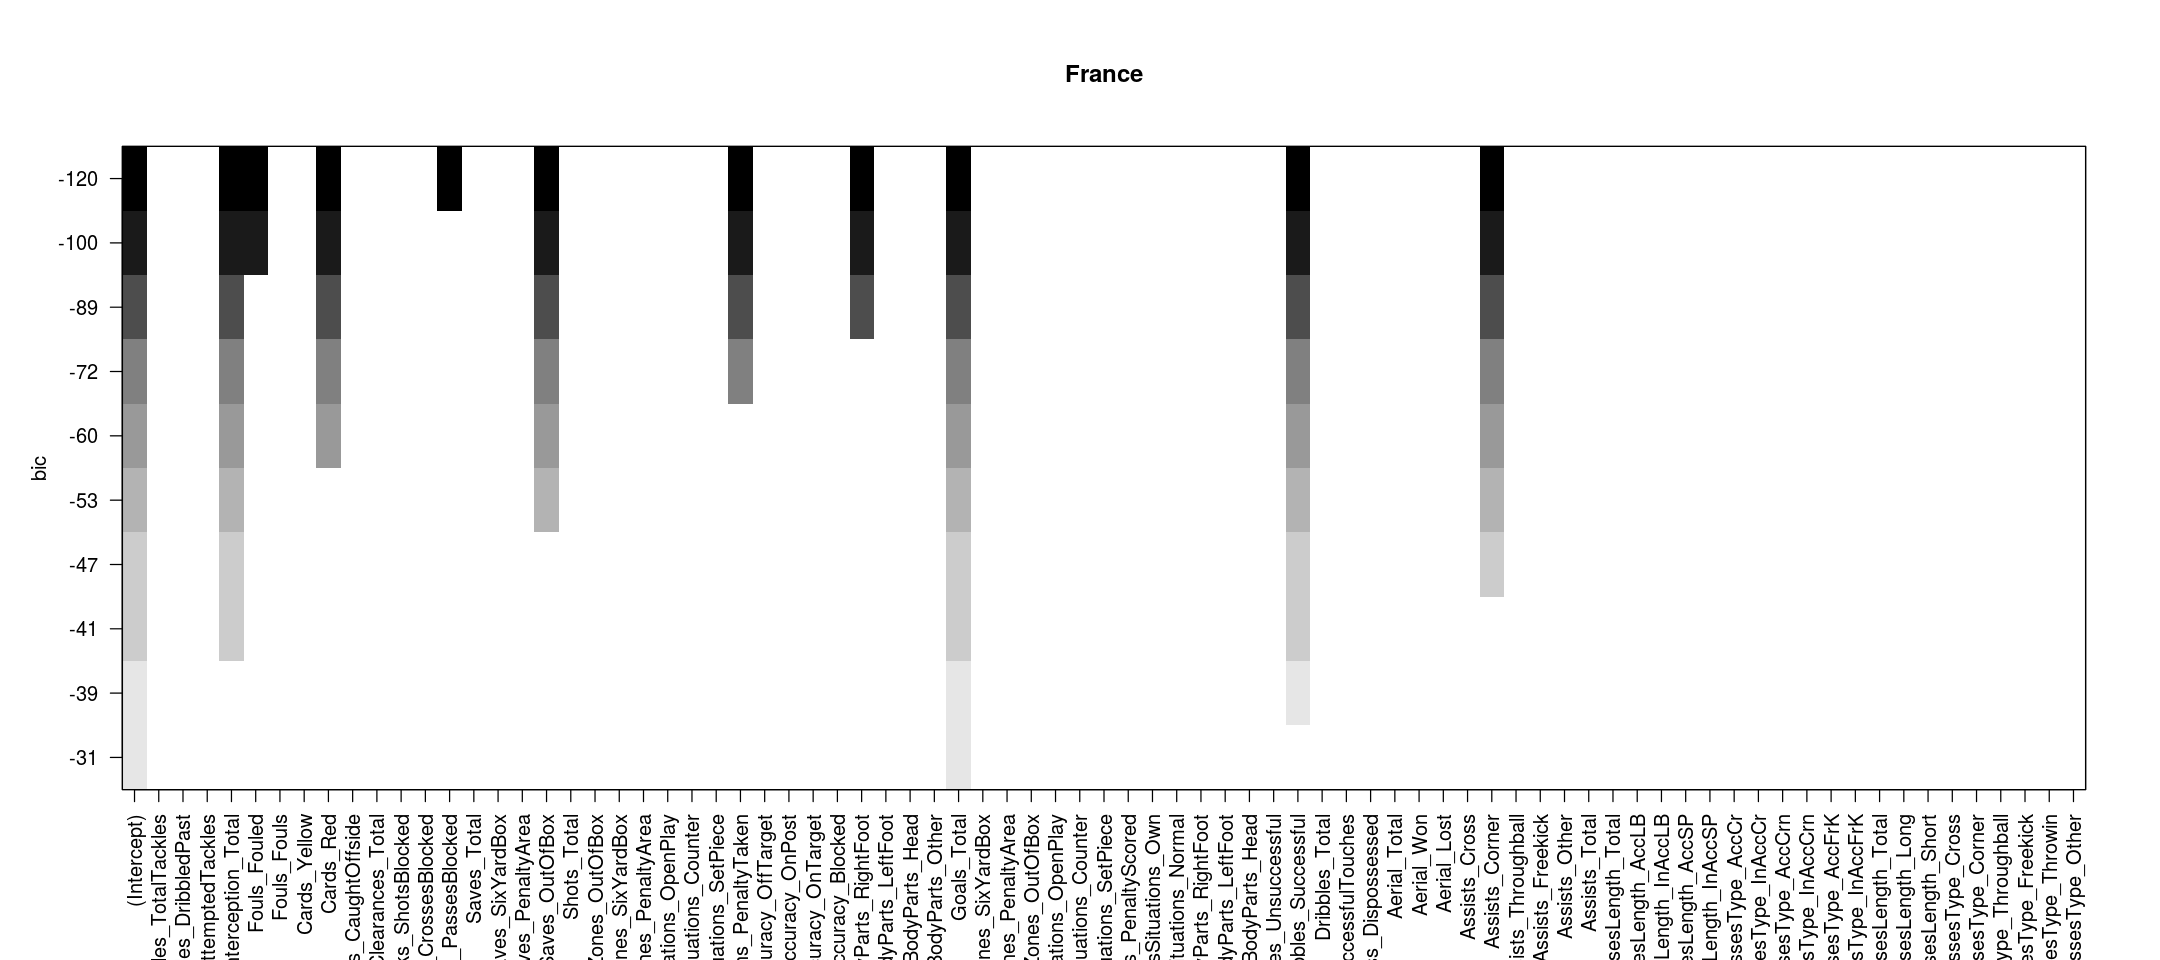

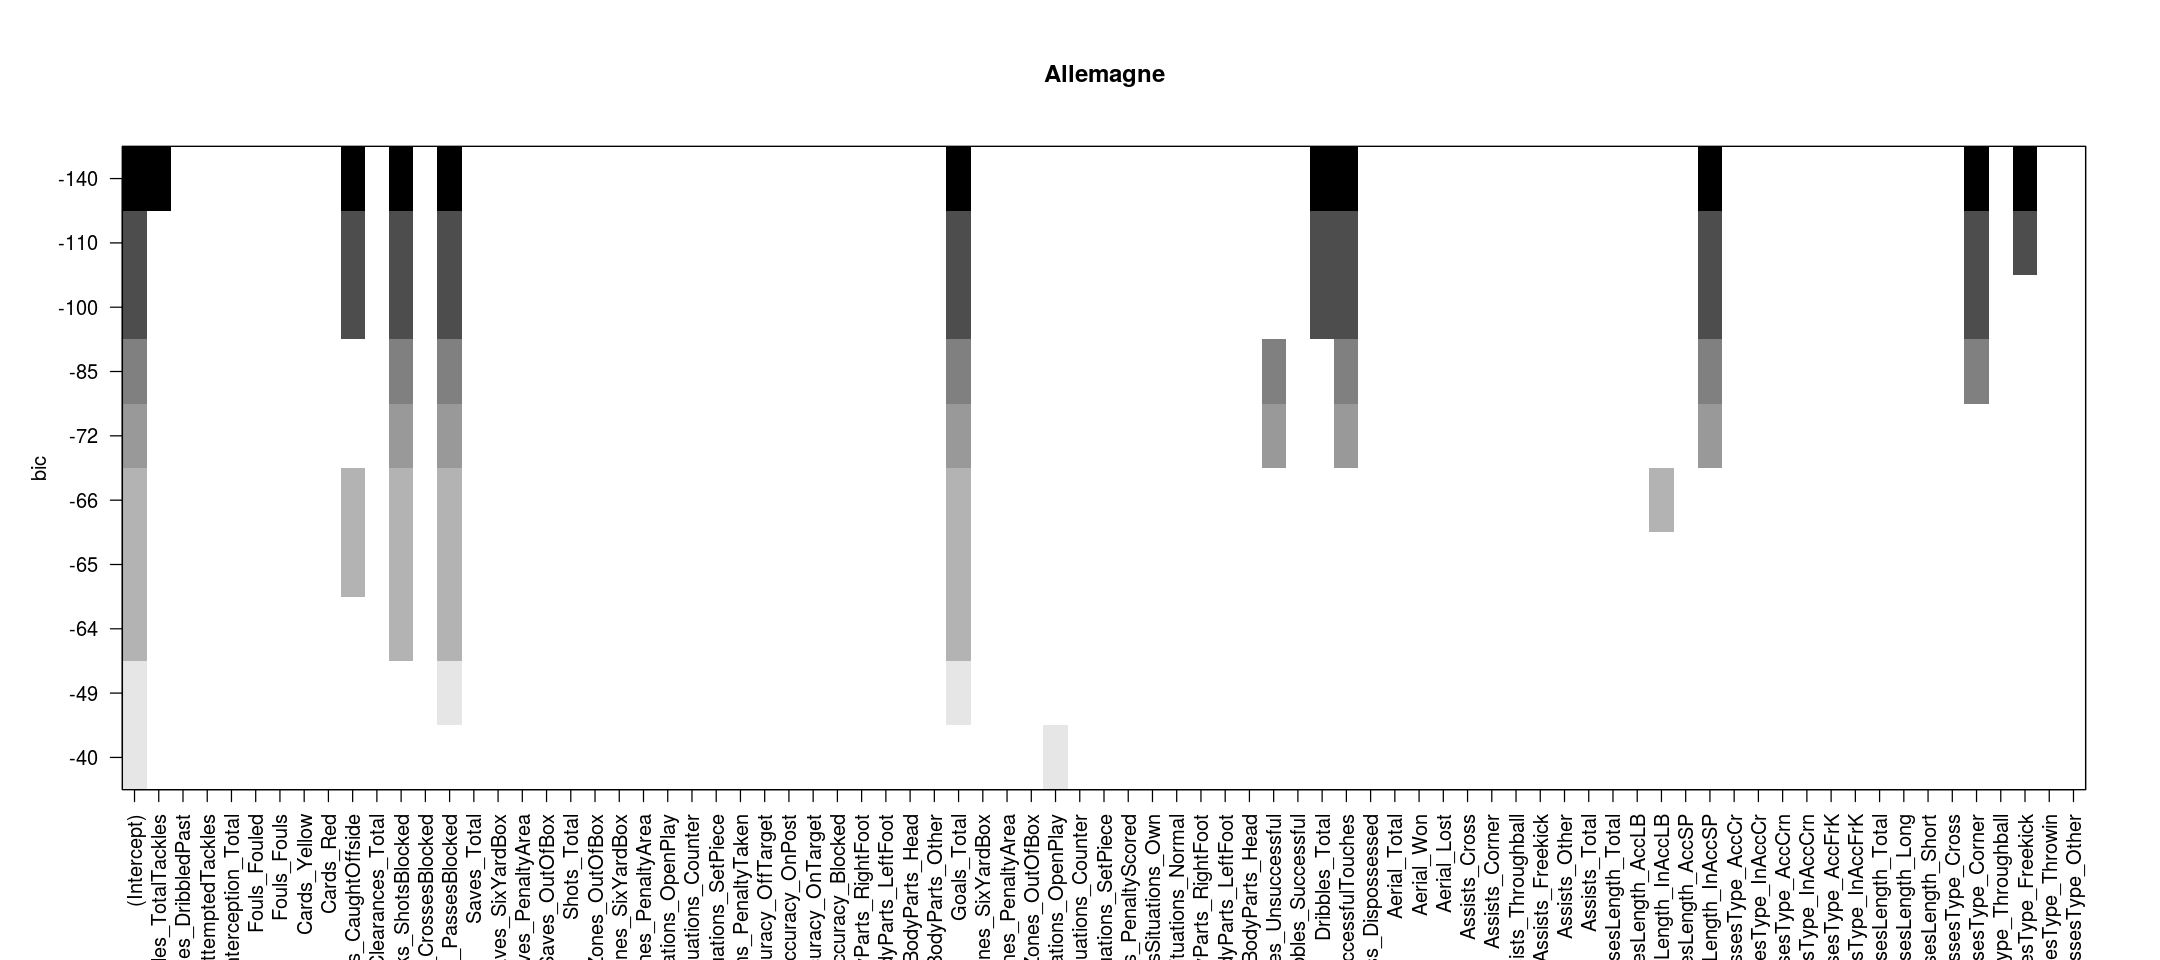

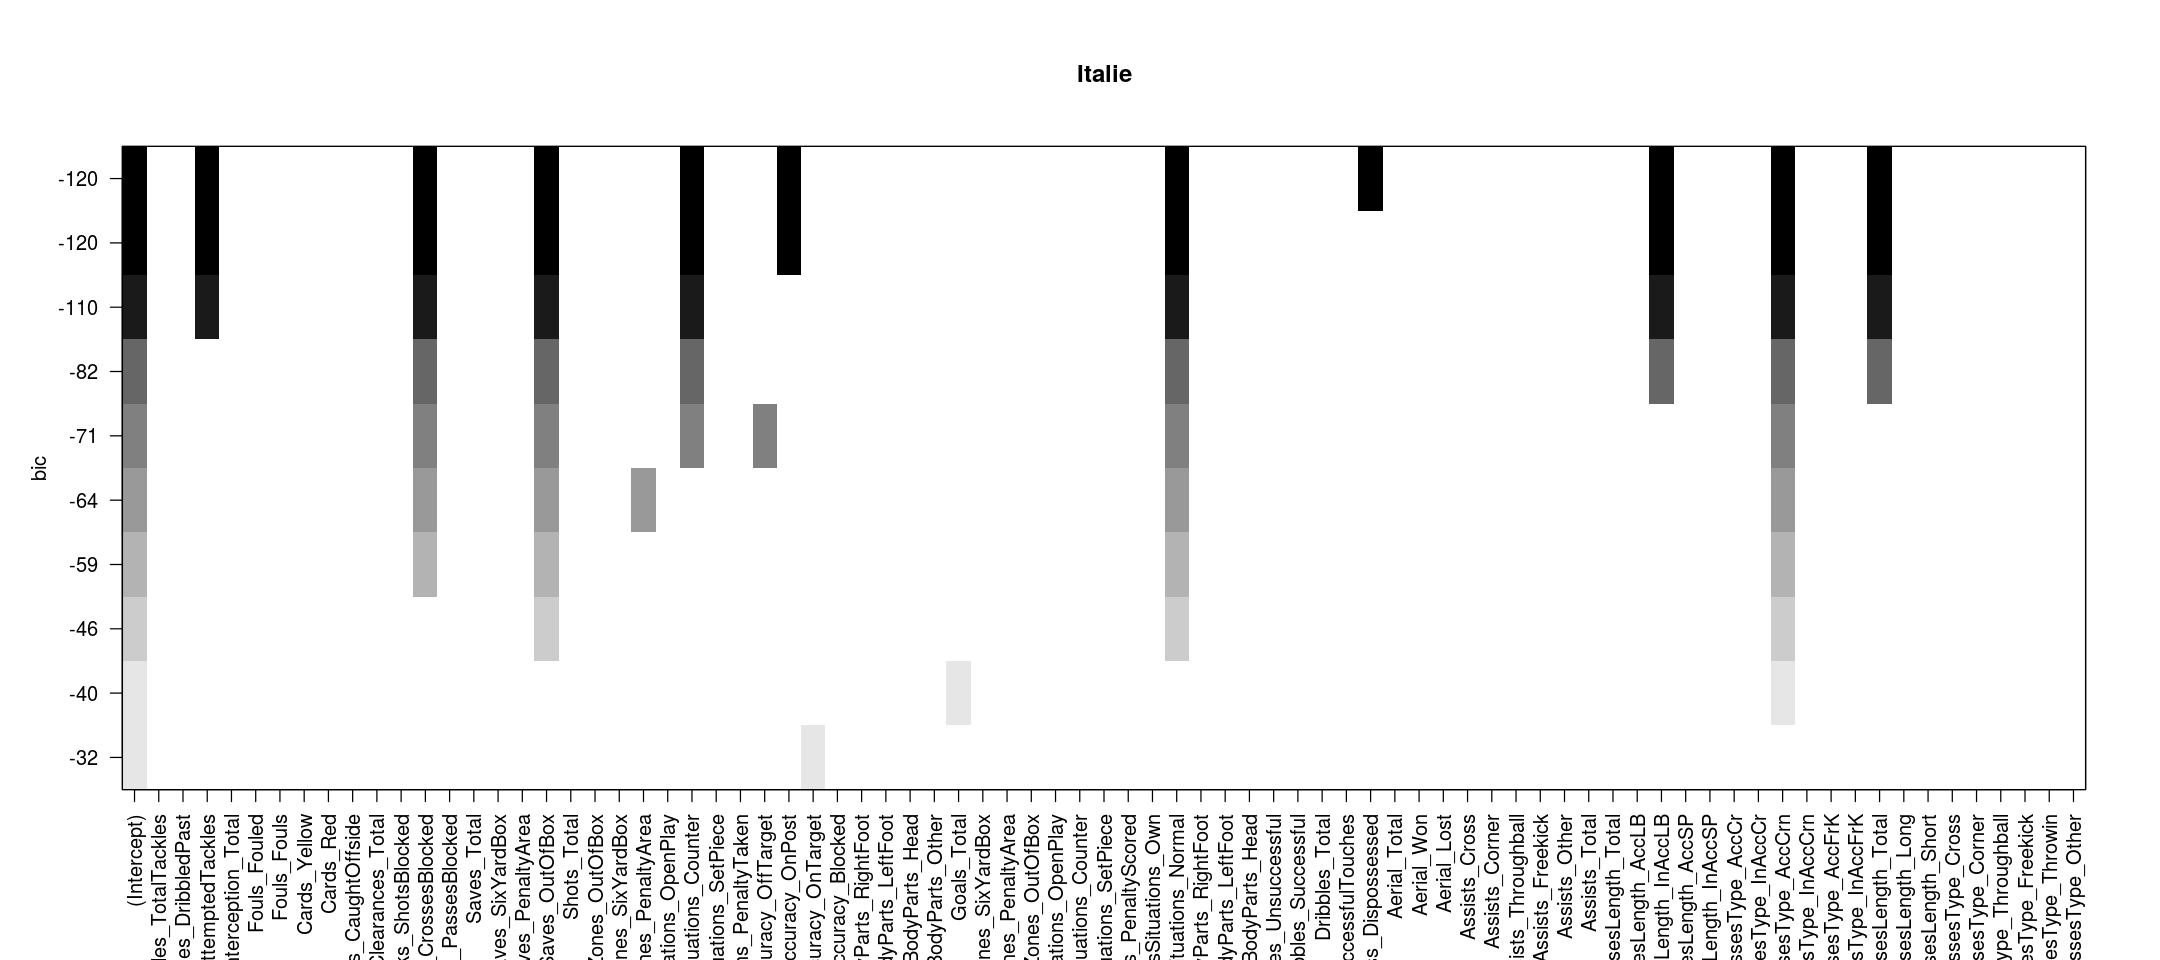

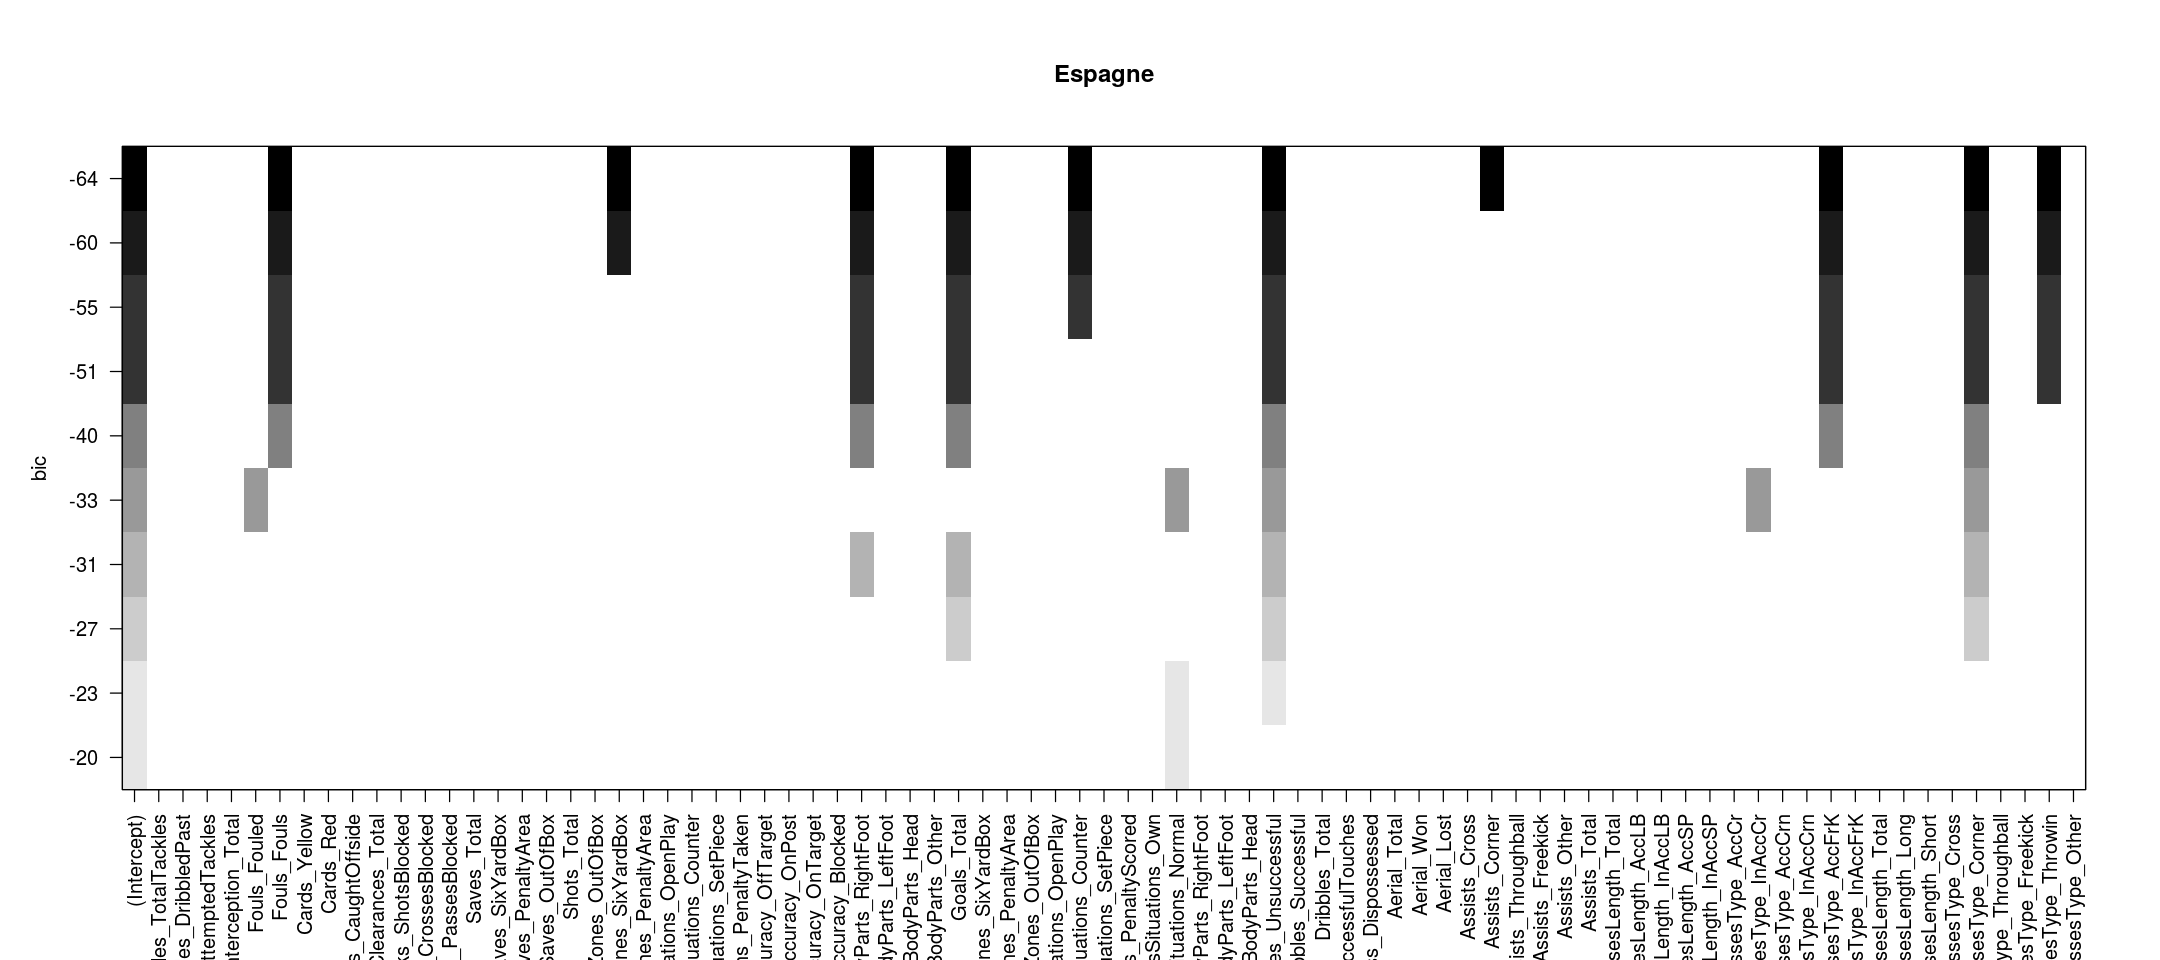

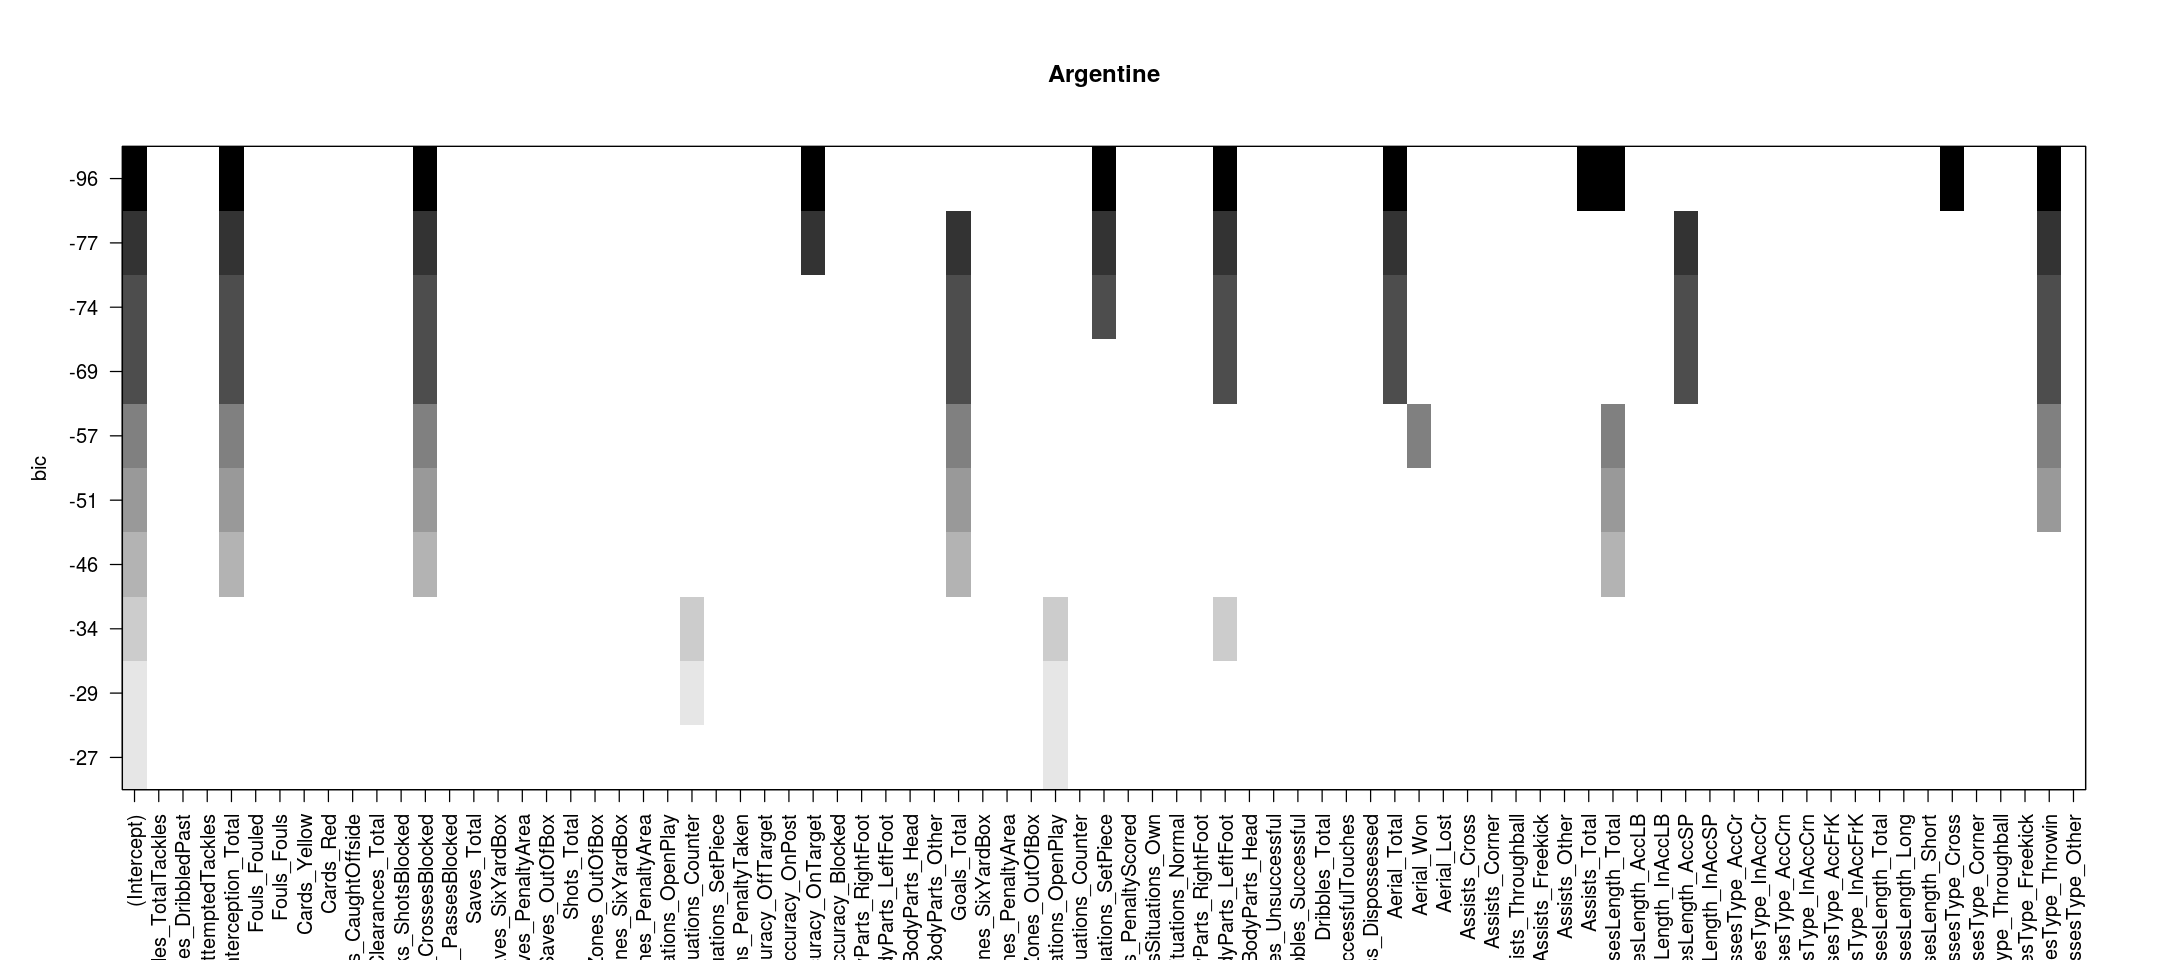

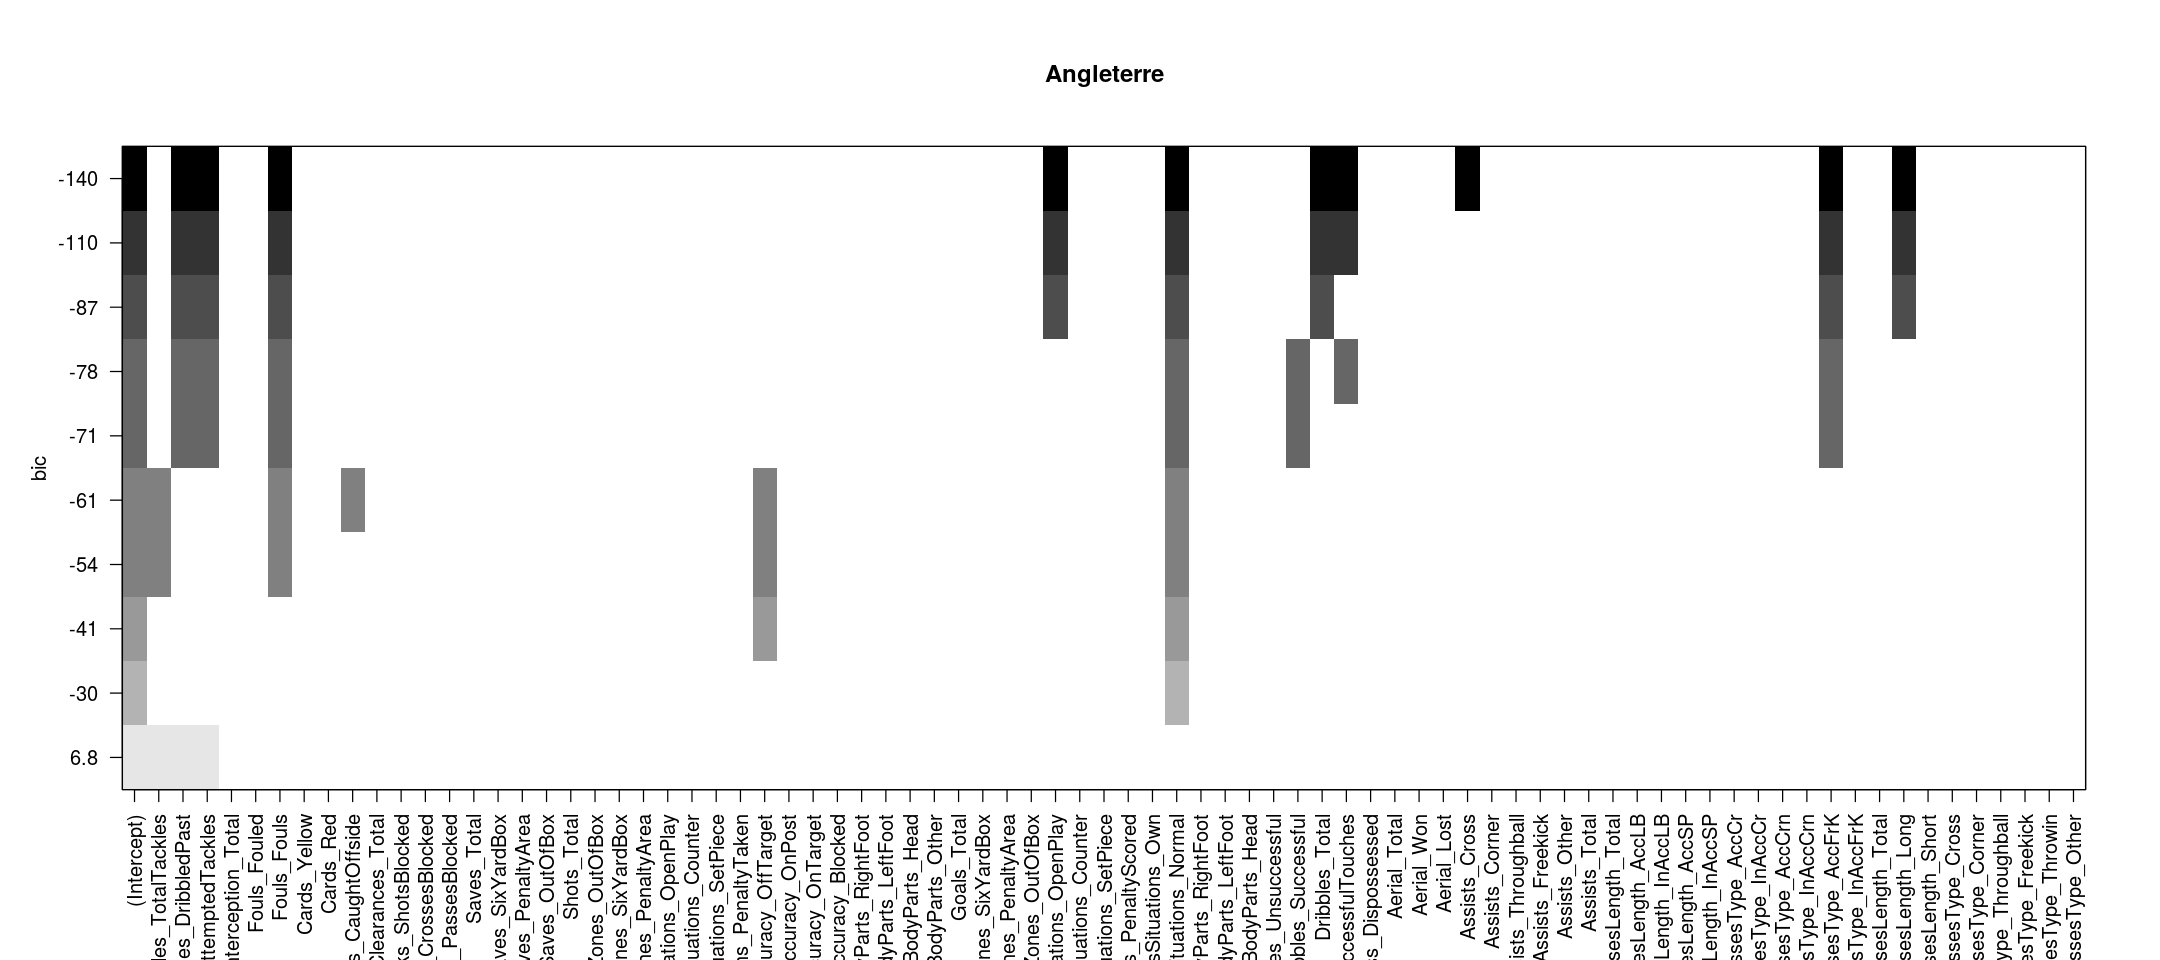

In [61]:
plot(choix_France,scale="bic", main = "France")
plot(choix_Allemagne,scale="bic", main = "Allemagne")
plot(choix_Italie,scale="bic", main = "Italie")
plot(choix_Espagne,scale="bic", main = "Espagne")
plot(choix_Argentine,scale="bic", main = "Argentine")
plot(choix_Angleterre,scale="bic", main = "Angleterre")

On voit que les variables retenues ne sont pas les mêmes d'un pays à l'autre. On va les afficher.

In [62]:
nb_min = which.min(summary(choix_France)$bic)
coef(choix_France, nb_min)

(Intercept)           Interception_Total 
                  6.13982139                   0.02379254 
                Fouls_Fouled                    Cards_Red 
                  0.00780852                  -0.59998996 
        Blocks_PassesBlocked               Saves_OutOfBox 
                  0.00953064                  -0.15869606 
ShotsSituations_PenaltyTaken     ShotsBodyParts_RightFoot 
                 -0.29921044                   0.01058761 
                 Goals_Total          Dribbles_Successful 
                  0.24884230                   0.01447643 
              Assists_Corner 
                 -0.68520084

In [63]:
nb_min = which.min(summary(choix_Allemagne)$bic)
coef(choix_Allemagne, nb_min)

(Intercept)              Tackles_TotalTackles 
                      6.399091359                      -0.003078383 
           OffSides_CaughtOffside               Blocks_ShotsBlocked 
                      0.019588687                      -0.100248996 
             Blocks_PassesBlocked                       Goals_Total 
                      0.031203035                       0.254083488 
                   Dribbles_Total PossesionLoss_UnsuccessfulTouches 
                     -0.010802187                       0.032990789 
             PassesLength_InAccSP              KeyPassesType_Corner 
                     -0.006534990                       0.042078310 
           KeyPassesType_Freekick 
                      0.031796647

In [64]:
nb_min = which.min(summary(choix_Italie)$bic)
coef(choix_Italie, nb_min)

(Intercept) Tackles_TotalAttemptedTackles 
                  6.121935479                  -0.006314372 
        Blocks_CrossesBlocked                Saves_OutOfBox 
                  0.082943752                  -0.107609112 
      shotsSituations_Counter          ShotsAccuracy_OnPost 
                 -0.162027230                   0.047045670 
       GoalsSituations_Normal    PossesionLoss_Dispossessed 
                  0.220527721                   0.002141677 
         PassesLength_InAccLB             PassesType_AccCrn 
                  0.004099711                   0.074177992 
        KeyPassesLength_Total 
                  0.015484516

In [65]:
nb_min = which.min(summary(choix_Espagne)$bic)
coef(choix_Espagne, nb_min)

(Intercept)              Fouls_Fouls    ShotsZones_SixYardBox 
              5.30226068               0.06033281              -0.04943554 
ShotsBodyParts_RightFoot              Goals_Total  GoalsSituations_Counter 
             -0.09519753               0.64617737               0.31190463 
   Dribbles_Unsuccessful           Assists_Corner        PassesType_AccFrK 
             -0.07732713               0.16209235               0.04389401 
    KeyPassesType_Corner    KeyPassesType_Throwin 
              0.44535170               0.51258696

In [66]:
nb_min = which.min(summary(choix_Argentine)$bic)
coef(choix_Argentine, nb_min)

(Intercept)       Interception_Total    Blocks_CrossesBlocked 
            5.1672585707             0.0155505147             0.1189540982 
  ShotsAccuracy_OnTarget GoalsSituations_SetPiece  GoalsBodyParts_LeftFoot 
            0.0553495653             0.1588745808             0.2386931484 
            Aerial_Total            Assists_Total       PassesLength_Total 
            0.0062889447             0.1182705930             0.0009981764 
     KeyPassesType_Cross    KeyPassesType_Throwin 
            0.0280459865             0.3306468666

In [67]:
nb_min = which.min(summary(choix_Angleterre)$bic)
coef(choix_Angleterre, nb_min)

(Intercept)              Tackles_DribbledPast 
                       6.49408040                       -0.05867852 
    Tackles_TotalAttemptedTackles                       Fouls_Fouls 
                       0.02742058                       -0.02856630 
         GoalsSituations_OpenPlay            GoalsSituations_Normal 
                       0.10241306                        0.23551565 
                   Dribbles_Total PossesionLoss_UnsuccessfulTouches 
                       0.01154699                       -0.01034876 
                    Assists_Cross                 PassesType_AccFrK 
                       0.06008585                       -0.01667785 
             KeyPassesLength_Long 
                       0.03663127

On remarque que c'est seulement en France, Allemagne et Espagne que la variable `Goals_Total` est sélectionnée.